# Defining MLP

In [3]:
# import os
# os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
# print(os.getcwd())

In [18]:
import os
os.chdir('c:\\Users\\mikol\\Documents\\Computational_Intelligence_Methods\\Computational_Intelligence_Methods')
print(os.getcwd())

c:\Users\mikol\Documents\Computational_Intelligence_Methods\Computational_Intelligence_Methods


In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [20]:
def sigmoid(x):
    # x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [21]:
def relu(x):
    """ReLU activation function: f(x) = max(0, x)"""
    return np.maximum(0,x)

In [22]:
def relu_derivative(x):
    """Derivative of ReLU activation function: f'(x) = 1 if x > 0 else 0"""
    return np.where(x > 0, 1, 0)

In [23]:
def sigmoid_derivative(x):
    # Corrected sigmoid derivative to properly compute the derivative
    return sigmoid(x) * (1 - sigmoid(x))

In [24]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [25]:
class MLP:
    
    def __init__(self, layer_sizes, activation_function=sigmoid, activation_function_derivative=sigmoid_derivative):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(y, x) * np.sqrt(1.0 / x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        self.velocity = [np.zeros_like(w) for w in self.weights]
        self.cache = [np.zeros_like(w) for w in self.weights]
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative

        print(self.weights)

    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:")
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            print(f"Layer {i + 1} Weights:\n{w}")
            print(f"Layer {i + 1} Biases:\n{b}")

    def feedforward(self, a):
        activations = [a]  # Stores all activations
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = self.activation_function(np.dot(w, a)+ b) 
            activations.append(a)
        # Linear activation for the last layer
        a = np.dot(self.weights[-1], a) + self.biases[-1]
        activations.append(a)
        return activations[-1], activations  # Return final activation and all activations

    def backprop(self, x, y):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [np.dot(w, act) + b for w, b, act in zip(self.weights, self.biases, activations[:-1])]  # Z values

        # Output layer error
        delta = self.cost_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            sp = self.activation_function_derivative(zs[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n, optimization_method='sgd', beta=0.9, epsilon=1e-8):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        if optimization_method == 'sgd':
            self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        elif optimization_method == 'momentum':
            self.velocity = [beta * v + (1 - beta) * nw for v, nw in zip(self.velocity, nabla_w)]
            self.weights = [w - (learning_rate / len(mini_batch)) * v for w, v in zip(self.weights, self.velocity)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        elif optimization_method == 'rmsprop':
            self.cache = [beta * c + (1 - beta) * (nw**2) for c, nw in zip(self.cache, nabla_w)]
            self.weights = [w - (learning_rate / (np.sqrt(c) + epsilon)) * nw for w, c, nw in zip(self.weights, self.cache, nabla_w)]
            self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        else:
            raise ValueError("Unsupported optimization method")

    def train(self, training_data, epochs, learning_rate, batch_size, lambda_=0.0, update_method = 'batch', optimization_method='sgd', beta=0.9, epsilon=1e-8, plot_interval=None, visual_interval=100, mse_limit=None, X_val_scaled=None, y_val_scaled=None, X_val=None, y_val=None, scaler_X=None, scaler_y=None):
    
        mse_history = []
        n = len(training_data)
        learning_rate_init = learning_rate

        for j in range(epochs):
            # Plot weights at the specified interval
            if plot_interval and j % plot_interval == 0:
                print(f"Epoch {j}:")
                self.plot_weights()

            np.random.shuffle(training_data)

            # Determine actual batch size
            actual_batch_size = int(batch_size * n) if isinstance(batch_size, float) else batch_size

            if update_method == 'batch':
                mini_batches = [training_data[k:k + actual_batch_size] for k in range(0, n, actual_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n, optimization_method, beta, epsilon)
            elif update_method == 'epoch':
                self.update_mini_batch(training_data, learning_rate, lambda_, n, optimization_method, beta, epsilon)
            # Learning rate schedule
            # learning_rate = learning_rate_init / (1 + 0.01 * j)
            
            if j % visual_interval == 0 or j == epochs - 1:
                # Generate predictions for the validation set
                predictions_scaled_mse = np.array(
                    [self.feedforward(x.reshape(-1, 1))[0] for x in X_val_scaled])

                # Inverse transform the scaled predictions back to their original scale
                predictions_mse = scaler_y.inverse_transform(predictions_scaled_mse.reshape(-1, 1))

                # Calculate the mean squared error on the validation set
                current_mse = mse(predictions_mse, y_val)
                # Append the MSE to the history for tracking
                mse_history.append((j, current_mse))
                # Print the current epoch and its MSE
                print(f'Epoch {j}, MSE: {current_mse}')

                # If a threshold for MSE is set and the current MSE is below this threshold, stop training
                if mse_limit is not None and current_mse < mse_limit:
                    break

        # Return the history of MSE values
        return mse_history


    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    
    def visualize_network_working(self):
        fig, ax = plt.subplots()

        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))

            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)

        plt.show()
        
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()

In [26]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [27]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [28]:
pwd

'c:\\Users\\mikol\\Documents\\Computational_Intelligence_Methods\\Computational_Intelligence_Methods'

In [29]:
df_train_square_large = pd.read_csv('./data/regression/square-large-training.csv')
df_test_square_large = pd.read_csv('./data/regression/square-large-test.csv')

In [30]:
df_train_steps_large = pd.read_csv('./data/regression/steps-large-training.csv')
df_test_steps_large = pd.read_csv('./data/regression/steps-large-test.csv')

In [31]:
df_train_multimodal_large = pd.read_csv('./data/regression/multimodal-large-training.csv')
df_test_multimodal_large = pd.read_csv('./data/regression/multimodal-large-test.csv')

In [32]:
X_train_square_large = df_train_square_large['x'].values.reshape(-1, 1)
y_train_square_large = df_train_square_large['y'].values.reshape(-1, 1)

In [33]:
X_test_square_large = df_test_square_large['x'].values.reshape(-1, 1)
y_test_square_large = df_test_square_large['y'].values.reshape(-1, 1)

In [34]:
X_train_steps_large = df_train_steps_large['x'].values.reshape(-1, 1)
y_train_steps_large = df_train_steps_large['y'].values.reshape(-1, 1)

In [35]:
X_test_steps_large = df_test_steps_large['x'].values.reshape(-1, 1)
y_test_steps_large = df_test_steps_large['y'].values.reshape(-1, 1)

In [36]:
X_train_multimodal_large = df_train_multimodal_large['x'].values.reshape(-1, 1)
y_train_multimodal_large = df_train_multimodal_large['y'].values.reshape(-1, 1)

In [37]:
X_test_multimodal_large = df_test_multimodal_large['x'].values.reshape(-1, 1)
y_test_multimodal_large = df_test_multimodal_large['y'].values.reshape(-1, 1)

### square-large dataset

In [38]:
scaler_X = DataScaler("standardization")
scaler_y = DataScaler("standardization")

In [39]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_square_large)
y_train_scaled = scaler_y.fit_transform(y_train_square_large)


In [40]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_square_large)
y_test_scaled = scaler_y.transform(y_test_square_large)

In [41]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square_large, y_train_square_large)]

In [42]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [46]:
mlp1 = MLP([1, 6, 1] , activation_function=sigmoid, activation_function_derivative=sigmoid_derivative)

[array([[ 1.4215151 ],
       [-0.24569762],
       [ 0.43123402],
       [-0.81890881],
       [ 0.46661329],
       [ 2.21528584]]), array([[-0.61153069,  0.72935816,  0.05339201, -0.23469007,  0.56089371,
        -0.33200113]])]


In [49]:
mse_1_momentum = mlp1.train(
    training_data_scaled, epochs=200000, learning_rate=0.4, batch_size=20,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_large, y_val=y_test_square_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, update_method='batch', optimization_method='momentum', beta=0.9,
    visual_interval=10
)

Epoch 0, MSE: 19.61208754612621
Epoch 10, MSE: 19.574693124897077
Epoch 20, MSE: 19.567855164973864
Epoch 30, MSE: 19.620297858555777
Epoch 40, MSE: 19.615507618868307
Epoch 50, MSE: 19.511399883405062
Epoch 60, MSE: 19.499331434733193
Epoch 70, MSE: 19.564306499056297
Epoch 80, MSE: 19.433197076872787
Epoch 90, MSE: 19.50237394847874
Epoch 100, MSE: 19.537950584775178
Epoch 110, MSE: 19.577870189254543
Epoch 120, MSE: 19.55702470116082
Epoch 130, MSE: 19.432619975271162
Epoch 140, MSE: 19.5156876075128
Epoch 150, MSE: 19.49638312921572
Epoch 160, MSE: 19.52006947382071
Epoch 170, MSE: 19.541056996625112
Epoch 180, MSE: 19.524731393961435
Epoch 190, MSE: 19.54028364503231
Epoch 200, MSE: 19.52631353071524
Epoch 210, MSE: 19.6069459691879
Epoch 220, MSE: 19.458122308944176
Epoch 230, MSE: 19.5434819771921
Epoch 240, MSE: 19.4189682784366
Epoch 250, MSE: 19.504268958932045
Epoch 260, MSE: 19.494277215878697
Epoch 270, MSE: 19.462145270806744
Epoch 280, MSE: 19.47443502927269
Epoch 290, M

KeyboardInterrupt: 

In [241]:
mlp2 = MLP([1, 5, 1] , activation_function=sigmoid, activation_function_derivative=sigmoid_derivative)

[array([[ 1.0557032 ],
       [-0.70082455],
       [-1.30012108],
       [ 0.46710407],
       [ 0.14828006]]), array([[-0.38861414,  0.02048307, -0.25424767,  0.42304254, -0.34558536]])]


In [242]:
mse_1_rms = mlp2.train(
    training_data_scaled, epochs=200000, learning_rate=0.4, batch_size=10,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_large, y_val=y_test_square_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, optimization_method='rmsprop', beta=0.9,
    visual_interval=10
)

Epoch 0, MSE: 15410.306491746875
Epoch 10, MSE: 5474.548746418171
Epoch 20, MSE: 5587.8809117398105
Epoch 30, MSE: 4476.469224519613
Epoch 40, MSE: 12193.404346269437
Epoch 50, MSE: 10159.93233104008
Epoch 60, MSE: 3263.3212804076534
Epoch 70, MSE: 5291.084604460127
Epoch 80, MSE: 5711.374100893191
Epoch 90, MSE: 5220.302218408473
Epoch 100, MSE: 2222.9378224806155
Epoch 110, MSE: 6089.713338155466
Epoch 120, MSE: 2195.1262358528033
Epoch 130, MSE: 4538.642682214212
Epoch 140, MSE: 3930.7358694714176
Epoch 150, MSE: 3697.634382111264
Epoch 160, MSE: 9203.60494916941
Epoch 170, MSE: 2415.8271818452517
Epoch 180, MSE: 2305.095870025399
Epoch 190, MSE: 2951.041720246831
Epoch 200, MSE: 3617.2272162674553
Epoch 210, MSE: 2076.4352780390564
Epoch 220, MSE: 9138.315339426936
Epoch 230, MSE: 2421.367893663835
Epoch 240, MSE: 4466.381712704895
Epoch 250, MSE: 4247.420835598286
Epoch 260, MSE: 2120.9884197620354
Epoch 270, MSE: 2177.841274432704
Epoch 280, MSE: 3193.791565440461
Epoch 290, MSE:

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_10759/2050502511.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


Epoch 28800, MSE: 1330.5291410660504
Epoch 28810, MSE: 1301.8619852823515
Epoch 28820, MSE: 1468.3870324099692
Epoch 28830, MSE: 1511.479527216986
Epoch 28840, MSE: 1159.0929929789993
Epoch 28850, MSE: 4118.492544601831
Epoch 28860, MSE: 3063.758430430271
Epoch 28870, MSE: 1596.0672872217062
Epoch 28880, MSE: 1351.418601114621
Epoch 28890, MSE: 2183.270557591312
Epoch 28900, MSE: 925.3597076489435
Epoch 28910, MSE: 1189.162561413386
Epoch 28920, MSE: 2744.6802509493077
Epoch 28930, MSE: 8028.827511598639
Epoch 28940, MSE: 1950.4765622509985
Epoch 28950, MSE: 2940.923638512591
Epoch 28960, MSE: 3403.2590259446606
Epoch 28970, MSE: 4262.824443769312
Epoch 28980, MSE: 3028.8441610944074
Epoch 28990, MSE: 3042.6625990449816
Epoch 29000, MSE: 2468.6732459925347
Epoch 29010, MSE: 1163.1765736816506
Epoch 29020, MSE: 1575.0208427153138
Epoch 29030, MSE: 942.5421318417834
Epoch 29040, MSE: 1167.184818553247
Epoch 29050, MSE: 3025.964463945163
Epoch 29060, MSE: 2060.1874900124294
Epoch 29070, M

In [280]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

In [281]:
mse_1_momentum = list_to_dataframe(mse_1_momentum)
mse_1_rms = list_to_dataframe(mse_1_rms)

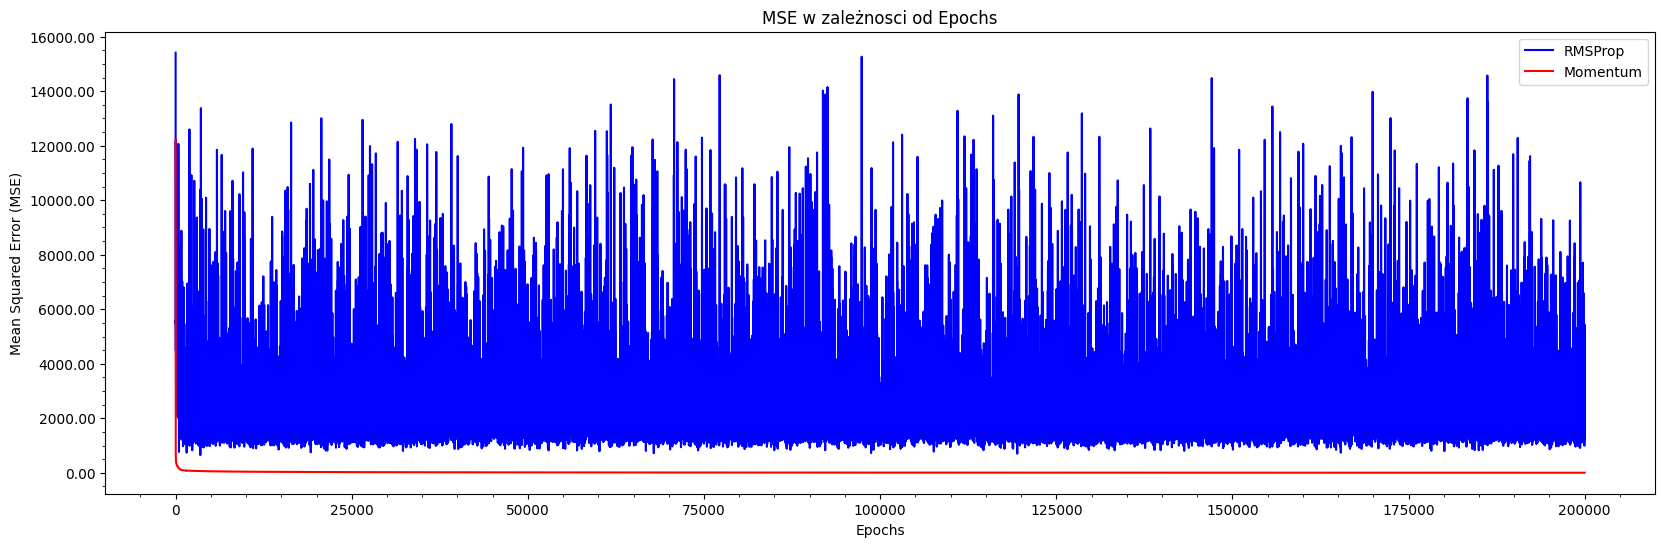

In [286]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(20, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.001)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_1_rms, mse_1_momentum]
labels = ['RMSProp', 'Momentum']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)

'''mlp2 = MLP([1, 5, 1] , activation_function=sigmoid, activation_function_derivative=sigmoid_derivative)
mse_1_rms = mlp2.train(
    training_data_scaled, epochs=200000, learning_rate=0.4, batch_size=10,
    X_val_scaled=X_test_scaled, y_val_scaled=y_test_scaled, X_val=X_test_square_large, y_val=y_test_square_large,
    scaler_X=scaler_X, scaler_y=scaler_y, mse_limit=4, optimization_method='rmsprop', beta=0.9,
    visual_interval=10
)
mse 0.7565299005584123'''


#### testing

In [95]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [96]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_square_large[i])
mse_score = mse(predictions, y_test_square_large)

print(f"MSE Score: {mse_score}")

predicted value:  [37.6449889] actual value:  [38.0481491]
predicted value:  [-116.21061884] actual value:  [-116.30927998]
predicted value:  [-22.62977895] actual value:  [-22.98888333]
predicted value:  [164.02687289] actual value:  [163.49243459]
predicted value:  [-51.13920952] actual value:  [-50.79309017]
predicted value:  [25.867231] actual value:  [26.14905307]
predicted value:  [-96.29967866] actual value:  [-95.99910634]
predicted value:  [-1.57886355] actual value:  [-1.67979449]
predicted value:  [12.52424981] actual value:  [11.84130953]
predicted value:  [-36.13737378] actual value:  [-36.5786339]
predicted value:  [-49.4247277] actual value:  [-49.85187483]
predicted value:  [-38.26385943] actual value:  [-38.70966897]
predicted value:  [-90.24870321] actual value:  [-89.65420844]
predicted value:  [135.89867942] actual value:  [151.89903669]
predicted value:  [-86.30049739] actual value:  [-86.1941224]
predicted value:  [150.62960535] actual value:  [172.6273849]
predic

### multimodal-large dataset

In [243]:
# Initialize the scaler for X and y with the desired scaling method
scaler_X = DataScaler(method="min_max")
scaler_y = DataScaler(method="min_max")

In [244]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_multimodal_large)
y_train_scaled = scaler_y.fit_transform(y_train_multimodal_large)


In [245]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_multimodal_large)
y_test_scaled = scaler_y.transform(y_test_multimodal_large)

In [246]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_multimodal_large, y_train_multimodal_large)]

In [247]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [248]:
mlp3 = MLP([1, 64, 32, 32, 1] )

[array([[-0.90158274],
       [ 0.67405136],
       [-0.66845666],
       [ 0.43675669],
       [-1.01958142],
       [-0.86957072],
       [-1.28917199],
       [-1.28977778],
       [ 0.68485893],
       [-0.21059798],
       [ 0.42522929],
       [-0.62003705],
       [-1.47249041],
       [-0.677023  ],
       [ 1.53391563],
       [-0.60521618],
       [ 0.26691154],
       [ 1.54807079],
       [-1.41517707],
       [ 0.37988187],
       [ 1.42820715],
       [-0.78837692],
       [-0.83568779],
       [ 1.36623251],
       [-0.04324884],
       [ 0.13028253],
       [ 0.9179078 ],
       [-0.1929195 ],
       [ 0.2851434 ],
       [ 0.40200456],
       [ 0.36042922],
       [ 0.11467439],
       [ 0.25327277],
       [-0.80348342],
       [ 0.83742618],
       [ 0.00816949],
       [-0.63298147],
       [ 0.98607498],
       [ 1.39707167],
       [ 0.79132824],
       [ 2.678894  ],
       [ 0.58539841],
       [-0.17707007],
       [ 1.0067656 ],
       [-0.27351399],
       [ 

In [249]:
mse_2_rms = mlp3.train(
    training_data_scaled, epochs=100000, learning_rate=0.01, batch_size=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
    mse_limit = 9, visual_interval = 10
)

Epoch 0, MSE: 2420.481821768681
Epoch 10, MSE: 52.08370257444592
Epoch 20, MSE: 6.118067625089367


In [253]:
mlp4 = MLP([1, 64, 32, 32, 1] )

[array([[ 6.74493777e-01],
       [ 2.11225834e+00],
       [-8.53900829e-01],
       [-4.35415276e-01],
       [ 6.22051969e-01],
       [-1.75663013e+00],
       [-5.80064255e-01],
       [-2.17548150e-03],
       [ 1.54313800e-03],
       [ 1.50712764e+00],
       [ 3.89627315e-01],
       [ 2.41115256e+00],
       [ 1.14166078e+00],
       [-9.36801422e-01],
       [-2.80699799e-01],
       [ 1.51407493e+00],
       [-1.21222757e+00],
       [-4.90890153e-01],
       [ 4.20125948e-01],
       [ 8.42870226e-02],
       [-3.85226147e-01],
       [ 1.63781081e-01],
       [-5.19250519e-02],
       [ 1.57231497e+00],
       [-6.08068521e-01],
       [-3.43629419e-01],
       [ 7.01059413e-02],
       [-8.97751722e-01],
       [ 7.10442747e-01],
       [ 7.49067510e-01],
       [-6.98216994e-03],
       [ 1.53578880e+00],
       [-2.51090423e-01],
       [-9.22111488e-01],
       [-9.26454971e-01],
       [-4.30266487e-01],
       [-7.87024691e-01],
       [-8.80216587e-01],
       [-5.

In [254]:
mse_2_momentum = mlp4.train(
    training_data_scaled, epochs=200, learning_rate=0.01, batch_size=10,
    optimization_method='momentum', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
    mse_limit = 9, visual_interval = 10
)

Epoch 0, MSE: 5220.8265990632435
Epoch 10, MSE: 5134.399466735322
Epoch 20, MSE: 4959.095816659835
Epoch 30, MSE: 4677.001016836309
Epoch 40, MSE: 4497.676784326973
Epoch 50, MSE: 4431.503512060345
Epoch 60, MSE: 4435.02537051908
Epoch 70, MSE: 4335.95851304918
Epoch 80, MSE: 4286.159446873311
Epoch 90, MSE: 4309.88037788609
Epoch 100, MSE: 4236.532236282013
Epoch 110, MSE: 4155.868982507457
Epoch 120, MSE: 4115.051316445362
Epoch 130, MSE: 4055.640826008689
Epoch 140, MSE: 4002.6979310342253
Epoch 150, MSE: 3965.868365320586
Epoch 160, MSE: 3893.6595812483374
Epoch 170, MSE: 3795.6666636887508
Epoch 180, MSE: 3790.9284076348617
Epoch 190, MSE: 3631.8805614510447
Epoch 199, MSE: 3366.3020329397323


In [267]:
mse_2_momentum = list_to_dataframe(mse_2_momentum)
mse_2_rms = list_to_dataframe(mse_2_rms)

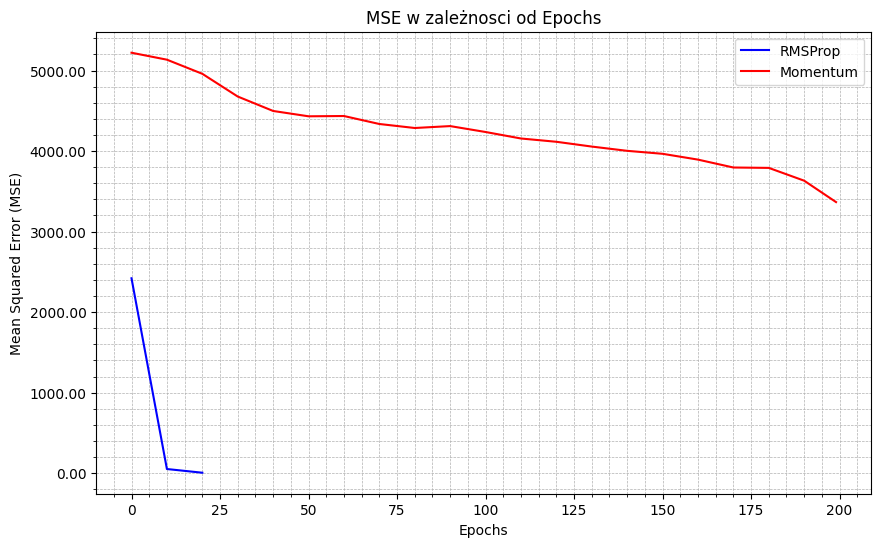

In [268]:
# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_2_rms, mse_2_momentum]
labels = ['RMSProp', 'Momentum']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)

'''mlp3 = MLP([1, 64, 32, 32, 1] )
mse_2_rms = mlp3.train(
    training_data_scaled, epochs=100000, learning_rate=0.01, batch_size=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
    mse_limit = 9, visual_interval = 10
)
mse 6.118067625089367
'''


#### testing

In [144]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [145]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_multimodal_large[i])
mse_score = mse(predictions, y_test_multimodal_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-92.83002761] actual value:  [-98.2081664]
predicted value:  [-38.66384059] actual value:  [-55.28389066]
predicted value:  [104.73325447] actual value:  [100.29999676]
predicted value:  [5.17204953] actual value:  [2.7206294]
predicted value:  [-60.69327864] actual value:  [-75.99163605]
predicted value:  [43.07936214] actual value:  [36.4875116]
predicted value:  [23.0753685] actual value:  [32.9071937]
predicted value:  [69.09462505] actual value:  [54.59378752]
predicted value:  [86.92638232] actual value:  [75.88595471]
predicted value:  [27.73449951] actual value:  [15.93020098]
predicted value:  [20.92591201] actual value:  [36.41048972]
predicted value:  [104.97060373] actual value:  [100.17958374]
predicted value:  [-94.4228396] actual value:  [-96.19000955]
predicted value:  [106.68526894] actual value:  [100.29859577]
predicted value:  [-49.29041946] actual value:  [-64.55778832]
predicted value:  [51.90255044] actual value:  [73.08482928]
predicted value:

### steps-large dataset

In [269]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")


In [270]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_steps_large)
y_train_scaled = scaler_y.fit_transform(y_train_steps_large)


In [271]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_steps_large)
y_test_scaled = scaler_y.transform(y_test_steps_large)

In [272]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_steps_large, y_train_steps_large)]

In [273]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [274]:
mlp5 = MLP([1, 5,5, 1] )

[array([[ 0.66910918],
       [-0.47040805],
       [-0.20847439],
       [ 1.36459568],
       [-2.26027896]]), array([[ 0.33380425, -0.52008324, -0.64529452,  0.38988378, -0.17801023],
       [-0.08332504, -0.36640706,  0.21267191,  0.0732805 ,  0.12581029],
       [-0.65012246, -0.14231256,  0.09301931, -0.26124096,  0.63396036],
       [ 1.23316558, -0.03331852, -0.43153604,  0.43936013,  0.04756133],
       [-0.72833803,  0.40661428, -1.08895916, -0.04976368,  0.2242263 ]]), array([[-0.87812317, -0.23663467,  0.19661884, -0.35046681, -0.24926899]])]


In [275]:
mse3_rms = mlp5.train(
    training_data_scaled, epochs=1000, learning_rate=0.01, batch_size=0.1,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)

Epoch 0, MSE: 8493.480189388722
Epoch 10, MSE: 983.4746281480346
Epoch 20, MSE: 587.6583382329732
Epoch 30, MSE: 529.4965393028963
Epoch 40, MSE: 520.0532059866489
Epoch 50, MSE: 510.8425400807711
Epoch 60, MSE: 501.10976226525077
Epoch 70, MSE: 498.51831560330663
Epoch 80, MSE: 499.21537642013465
Epoch 90, MSE: 502.19464417342135
Epoch 100, MSE: 493.8392473991822
Epoch 110, MSE: 493.05362448027626
Epoch 120, MSE: 492.077972323342
Epoch 130, MSE: 490.90887603277525
Epoch 140, MSE: 492.9827677994653
Epoch 150, MSE: 491.6237568844682
Epoch 160, MSE: 490.95376304990543
Epoch 170, MSE: 494.2139702521383
Epoch 180, MSE: 495.58644623687496
Epoch 190, MSE: 488.022792403626
Epoch 200, MSE: 502.9407419334121
Epoch 210, MSE: 487.5504444268788
Epoch 220, MSE: 488.79481974734836
Epoch 230, MSE: 496.87232358986347
Epoch 240, MSE: 489.3465580564682
Epoch 250, MSE: 495.0157064514984
Epoch 260, MSE: 489.6534495628496
Epoch 270, MSE: 495.7969685165241
Epoch 280, MSE: 486.7559094998629
Epoch 290, MSE: 4

In [276]:
mlp6 = MLP([1, 5,5, 1] )

[array([[ 0.08972407],
       [-0.84886028],
       [-0.11311401],
       [ 0.1750961 ],
       [ 1.52452128]]), array([[ 0.03052805, -0.06802923,  0.5188303 ,  0.12419796, -0.26759229],
       [-0.11403506,  1.01452047, -0.81337295,  0.1642102 , -0.17544065],
       [-0.41675979,  0.40673604,  0.15329708, -0.71568651,  0.33841273],
       [-0.06317713, -1.10047066,  0.34997254,  0.1687328 ,  0.53977391],
       [ 0.40911923,  0.25477267, -0.1011381 , -0.63339291,  0.29556817]]), array([[-0.0851085 ,  0.08252823,  0.44399534,  0.01796515, -0.38366811]])]


In [277]:
mse3_momentum = mlp6.train(
    training_data_scaled, epochs=1000, learning_rate=0.01, batch_size=0.1,
    optimization_method='momentum', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)

Epoch 0, MSE: 11029.803995096765
Epoch 10, MSE: 6902.044743213471
Epoch 20, MSE: 6785.370965506362
Epoch 30, MSE: 6665.180592778349
Epoch 40, MSE: 6537.847400129462
Epoch 50, MSE: 6399.2387218816575
Epoch 60, MSE: 6245.095578588164
Epoch 70, MSE: 6070.9557045035735
Epoch 80, MSE: 5871.997241722368
Epoch 90, MSE: 5643.457529199133
Epoch 100, MSE: 5380.596032417312
Epoch 110, MSE: 5079.759124519645
Epoch 120, MSE: 4738.672579161858
Epoch 130, MSE: 4359.0272169235395
Epoch 140, MSE: 3945.8260995673
Epoch 150, MSE: 3509.46763068094
Epoch 160, MSE: 3065.343788719171
Epoch 170, MSE: 2632.007308524923
Epoch 180, MSE: 2227.1991578193147
Epoch 190, MSE: 1866.5129932189543
Epoch 200, MSE: 1559.1780173653458
Epoch 210, MSE: 1308.7500374433046
Epoch 220, MSE: 1112.5119189213187
Epoch 230, MSE: 964.2585078206944
Epoch 240, MSE: 855.658075306995
Epoch 250, MSE: 778.0798734183605
Epoch 260, MSE: 723.8069452108434
Epoch 270, MSE: 686.4136693829331
Epoch 280, MSE: 660.8193486015156
Epoch 290, MSE: 643.

In [278]:
mse3_momentum = list_to_dataframe(mse3_momentum)
mse3_rms = list_to_dataframe(mse3_rms)

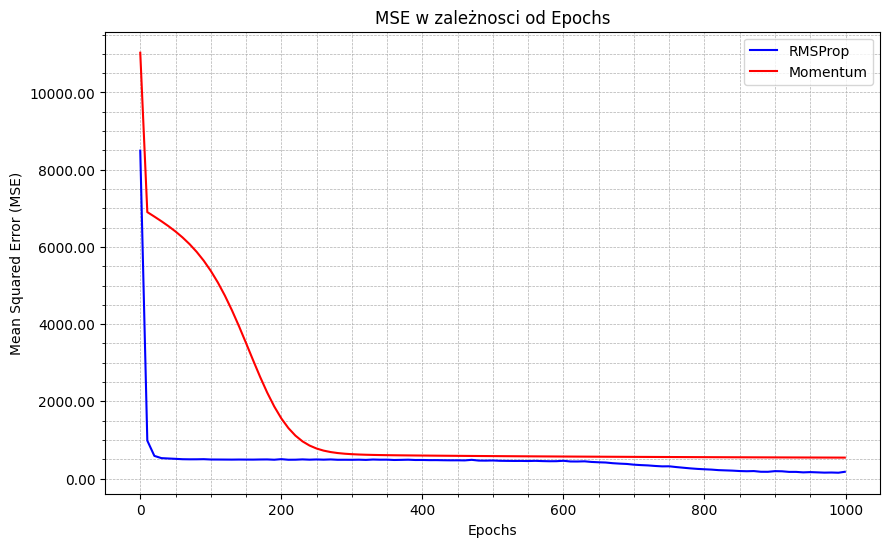

In [279]:
# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse3_rms, mse3_momentum]
labels = ['RMSProp', 'Momentum']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)

'''mlp5 = MLP([1, 5,5, 1] )
mse3_momentum = mlp6.train(
    training_data_scaled, epochs=1000, learning_rate=0.01, batch_size=0.1,
    optimization_method='momentum', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)
mse 175.54604196125257'''

#### testing

In [65]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [67]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_steps_large[i])
mse_score = mse(predictions, y_test_steps_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-97.52083727] actual value:  [-98.2081664]
predicted value:  [-54.25551153] actual value:  [-55.28389066]
predicted value:  [99.65196547] actual value:  [100.29999676]
predicted value:  [4.09228165] actual value:  [2.7206294]
predicted value:  [-73.86446255] actual value:  [-75.99163605]
predicted value:  [37.69087725] actual value:  [36.4875116]
predicted value:  [28.26103944] actual value:  [32.9071937]
predicted value:  [51.89040415] actual value:  [54.59378752]
predicted value:  [69.45158391] actual value:  [75.88595471]
predicted value:  [16.72811997] actual value:  [15.93020098]
predicted value:  [32.52955311] actual value:  [36.41048972]
predicted value:  [100.20211309] actual value:  [100.17958374]
predicted value:  [-95.59186227] actual value:  [-96.19000955]
predicted value:  [99.29064866] actual value:  [100.29859577]
predicted value:  [-63.8971626] actual value:  [-64.55778832]
predicted value:  [69.35791887] actual value:  [73.08482928]
predicted value: 

In [574]:
df_test_steps_large = pd.read_csv("data/regression/steps-large-test.csv")

X_test_steps_small = df_test_steps_large["x"].values.reshape(-1, 1)
y_test_steps_small = df_test_steps_large["y"].values.reshape(-1, 1)

In [575]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 0.22499592],
       [ 0.66393297],
       [ 0.81579735],
       [-0.93381363],
       [-1.56887485]]), array([[ 0.48408992, -0.90893581,  0.74451279,  0.26491836, -0.60762049],
       [ 0.21036234,  0.76803741,  0.00444413,  0.28424456, -0.40550138],
       [ 0.40071939, -0.39049337,  0.0533959 ,  0.28357303, -0.51281637],
       [-0.09733522,  0.20233363, -0.15237367, -0.91242117, -0.4788253 ],
       [ 0.66472232,  0.17079079,  0.40099151,  0.12026128,  0.05577142]]), array([[ 0.33198014, -0.44144792, -0.19640651, -0.21308176,  0.46809915]])]


In [576]:
# Fit and transform the training data
X_train_scaled2 = scaler_X.fit_transform(X_train_steps_small)
y_train_scaled2 = scaler_y.fit_transform(y_train_steps_small)


In [577]:
training_data_scaled2 = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled2, y_train_scaled2)
]

In [578]:
mlp_steps.train(
    training_data_scaled2, epochs=5000, learning_rate=0.1, batch_size=10
)

#### testing

In [579]:
# Scale the test data using the transform method
X_test_scaled2 = scaler_X.transform(X_test_steps_small)

In [580]:
# Generate predictions on the scaled test data
predictions_scaled2 = np.array(
    [mlp_steps.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled2]
)

In [581]:
# Correctly denormalize predictions
predictions2 = scaler_y.inverse_transform(predictions_scaled2.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions2)):
    print("predicted value: ",  predictions2[i], "actual value: ", y_test_steps_small[i])
mse_score2 = mse(predictions2, y_test_steps_small)

print(f"MSE Score: {mse_score2}")

predicted value:  [-75.68118152] actual value:  [-80]
predicted value:  [92.72419888] actual value:  [80]
predicted value:  [-88.27325684] actual value:  [-80]
predicted value:  [-70.89335599] actual value:  [-80]
predicted value:  [-78.9464397] actual value:  [-80]
predicted value:  [18.76146075] actual value:  [0]
predicted value:  [21.79168549] actual value:  [0]
predicted value:  [-87.52498457] actual value:  [-80]
predicted value:  [-74.5456806] actual value:  [-80]
predicted value:  [25.60761617] actual value:  [0]
predicted value:  [93.10415354] actual value:  [80]
predicted value:  [62.59932508] actual value:  [80]
predicted value:  [96.49685706] actual value:  [80]
predicted value:  [-75.53582894] actual value:  [-80]
predicted value:  [46.21620138] actual value:  [80]
predicted value:  [78.11865653] actual value:  [80]
predicted value:  [-18.89331856] actual value:  [0]
predicted value:  [146.8935984] actual value:  [160]
predicted value:  [-81.84228729] actual value:  [-80]


In [524]:
# nie ma optymalnego mse :((((